# Problem 7 (20 points)

## Problem Description
As a lecture activity, you performed support vector classification on a linearly separable dataset by solving the quadratic programming optimization problem to create a large margin classifier.

Now, you will use a similar approach to create a soft margin classifier on a dataset that is not cleanly separable.

Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:
Functions (described later):
- `soft_margin_svm(X,y,C)`

Results:
- Print the values of w1, w2, and b for the C=0.05 case

Plots:
- Plot the data with the optimized margin and decision boundary for the case C=0.05
- Make 4 such plots for the requested C values

Discussion:
- Respond to the prompt asked at the end of the notebook

#### Imports and Utility Functions:

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def plot_boundary(x, y, w1, w2, b, e=0.1):
    x1min, x1max = min(x[:,0]), max(x[:,0])
    x2min, x2max = min(x[:,1]), max(x[:,1])
    
    xb = np.linspace(x1min,x1max)
    y_0 = 1/w2*(-b-w1*xb)
    y_1 = 1/w2*(1-b-w1*xb)
    y_m1 = 1/w2*(-1-b-w1*xb)
    
    cmap = ListedColormap(["purple","orange"])

    plt.scatter(x[:,0],x[:,1],c=y,cmap=cmap)
    plt.plot(xb,y_0,'-',c='blue')
    plt.plot(xb,y_1,'--',c='green')
    plt.plot(xb,y_m1,'--',c='green')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.axis((x1min-e,x1max+e,x2min-e,x2max+e))

## Load data
Data is loaded as follows:  
- X: input features, Nx2 array  
- y: output class, length N array

In [50]:
data = np.load("data/w4-hw1-data.npy")
X = data[:, 0:2]
y = data[:, 2]

## Soft Margin SVM Optimization Problem

For soft-margin SVM, we introduce N slack variables $\xi_i$ (one for each point), and reformulate the optimization problem as:

$$
\min_{\boldsymbol{w}, b}\qquad \frac{1}{2}||\boldsymbol{w}||^2 + C \sum_i \xi_i
$$

$$
\text{subject to:}\quad y_i(\boldsymbol{w}^T \boldsymbol{x}_i+b)\geq 1 - \xi_i;\quad \xi_i \geq 0
$$

To put this into a form compatible with `cvxopt`, we will need to assemble large matrices as described in the next section.


## Soft Margin SVM function

Define a function `soft_margin_svm(X, y, C)` with inputs:
- `X`: (Nx2) array of input features
- `y`: Length N array of output classes, -1 or 1
- `C`: Regularization parameter

In this function, do the following steps:

1. Create the P, q, G, and h arrays for this problem (each comprised of multiple sub-matrices you need to combine into one)
- `P`: (3+N) x (3+N)
  - Upper left: Identity matrix, but with 0 instead of 1 for the bias (third) row/column
  - Upper right (3xN): Zeros
  - Lower left (Nx3): Zeros
  - Lower right: (NxN): Zeros
- `q`: (3+N) x (1)
  - Top (3x1): Vector of zeros
  - Bottom (Nx1): Vector filled with 'C'
- `G`: (N+N) x (N+3): 
  - Upper left (Nx3): Negative y multiplied element-wise by [`x1`, `x2`, `1`]
  - Upper right (NxN): Negative identity matrix
  - Lower left (Nx3): Zeros
  - Lower right (NxN): Negative identity matrix
- `h`: (N+N) x (1)
  - Top: Vector of -1
  - Bottom: Vector of zeros

You can use `np.block()` to combine multiple submatrices into one.

2. Convert each of these into cvxopt matrices (Provided)

3. Solve the problem using `cvxopt.solvers.qp` (Provided)

4. Extract the `w1`, `w2`, and `b` values from the solution, and return them (Provided)

In [51]:
def soft_margin_svm(X, y, C):
    N = np.shape(X)[0]

    # YOUR CODE GOES HERE
    # Define P, q, G, h
    P11 = np.ones([3,3])
    P11[-1,-1] = 0
    P = np.block([[P11,             np.zeros([3,N])],
                  [np.zeros([N,3]), np.zeros([N,N])]])
    q = np.block([np.zeros(3), C*np.ones(N)])
    G11 = np.array([np.array(-y*X[:,0]), np.array(-y*X[:,1]), -y*np.ones(N)]).T
    G = np.block([  [G11,               -1*np.eye(N)],
                    [np.zeros([N,3]),   -1*np.eye(N)]])
    h = np.block([-1*np.ones(N), np.zeros(N)])

    z = solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h))
    w1 = z['x'][0]
    w2 = z['x'][1]
    b  = z['x'][2]

    return w1, w2, b

## Demo: C = 0.05
Run the cell below to create the plot for the N = 0.05 case


Solution
--------
w1:  -0.7219
w2:   0.3057
 b:   2.9906


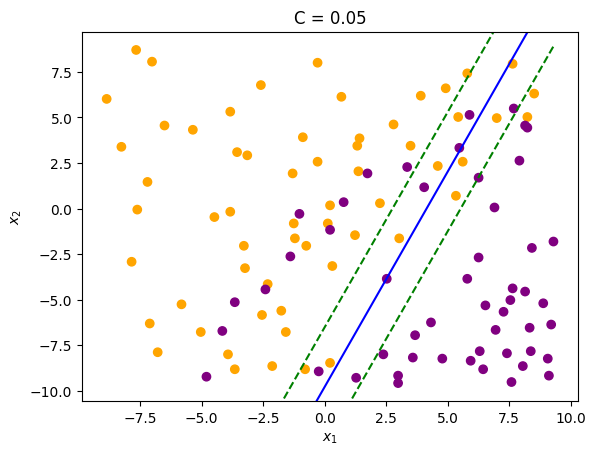

In [52]:
C = 0.05
w1, w2, b = soft_margin_svm(X, y, C)
print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

plt.figure()
plot_boundary(X,y,w1,w2,b,e=1)
plt.title(f"C = {C}")
plt.show()

## Varying C
Now loop over the C values [1e-5, 1e-3, 1e-2, 1] and generate soft margin decision boundary plots like the one above for each case.


Solution
--------
w1:  -0.1964
w2:   0.0300
 b:   0.8518

Solution
--------
w1:  -0.2121
w2:   0.0381
 b:   0.9094

Solution
--------
w1:  -0.2542
w2:   0.0968
 b:   1.0020

Solution
--------
w1:  -0.3168
w2:   0.1920
 b:   1.2915


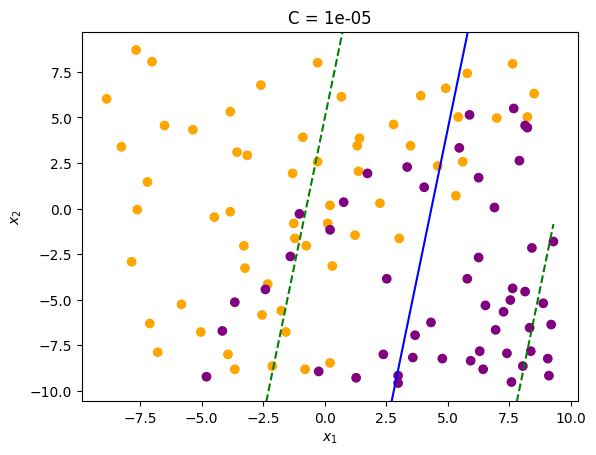

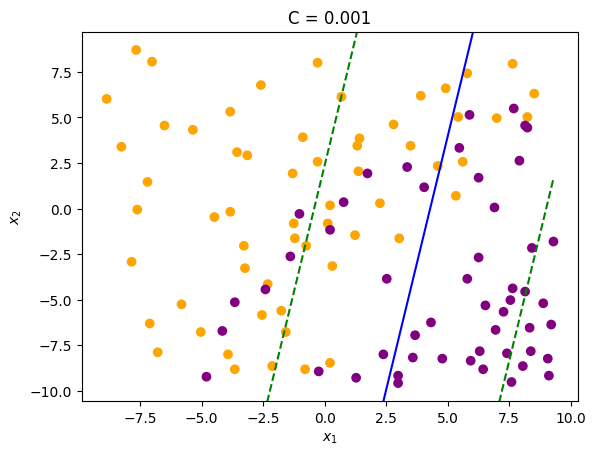

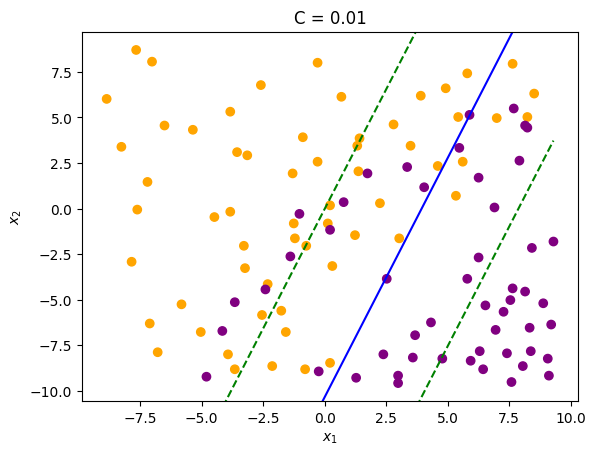

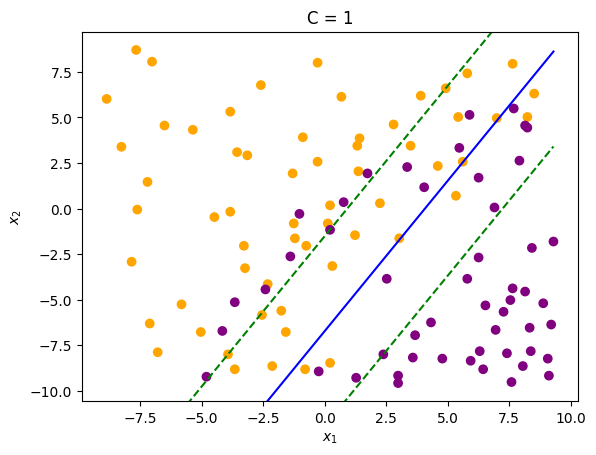

In [53]:
Cs = [1e-5, 1e-3, 1e-2, 1]
for C in Cs:
    w1, w2, b = soft_margin_svm(X, y, C)
    print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

    plt.figure()
    plot_boundary(X,y,w1,w2,b,e=1)
    plt.title(f"C = {C}")

plt.show()

## Discussion

Please write a sentence or two discussing what happens to the decision boundary and margin as you vary C, and try to provide some rationale for why.

As you decrease C, the decision boudary gets larger and the fit to the data gets progressively worse. This is because increasing C, descreases the overall effect of the lambda element in the optimization thus reducing the number of constraints on the final solution.